# Linear regression assignment (Bike sharing case study)

**Problem Statement:** A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.


A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.


They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors. 

## 0. Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. Loading and understanding the data

The given dataset has 730 rows and 16 columns. Below is the description of each columns

- **instant**: record index
- **dteday** : date
- **season** : season (1:spring, 2:summer, 3:fall, 4:winter)
- **yr** : year (0: 2018, 1:2019)
- **mnth** : month ( 1 to 12)
- **holiday** : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0.
- **weathersit** : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : temperature in Celsius
- **atemp**: feeling temperature in Celsius
- **hum**: humidity
- **windspeed**: wind speed
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

In [2]:
# data-loading

data = pd.read_csv('day.csv')
data.shape

(730, 16)

## 2. Dataset validations

In [3]:
# check for null or empty columns

data.isnull().mean()*100

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

In [4]:
# check header

data.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [5]:
# check footer

data.tail(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,31-12-2019,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


In [6]:
# check duplicate rows

data[data.duplicated()]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [7]:
# data check

data[data['casual'] + data['registered'] != data['cnt']]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [8]:
# data check

data[(data['temp'] < 0) | (data['atemp'] < 0) | (data['hum'] < 0) | (data['windspeed'] < 0)]

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


## 3. Basic EDA on data

In [9]:
# data cleaning - remove unnecessary columns

data = data.drop(columns=['instant', 'dteday', 'registered', 'casual'], axis = 1)

In [10]:
# variables identification

target_var = 'cnt'
categorical_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
numeric_vars = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']

In [11]:
# change dtype of columns having categorical data

data[categorical_vars] = data[categorical_vars].apply(lambda x: x.astype('object'))

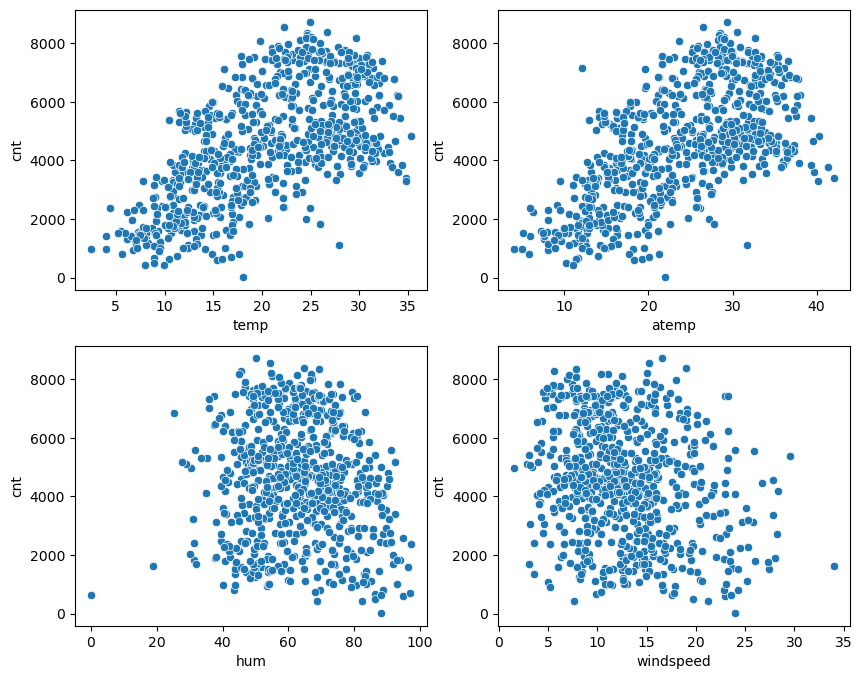

In [12]:
# scatter plot among numeric variables and target variable

plt.figure(figsize=(10, 8))

for i in range(1, len(numeric_vars)):
    plt.subplot(2, 2, i)
    sns.scatterplot(x = data[numeric_vars[i]], y = data[target_var])

plt.show()

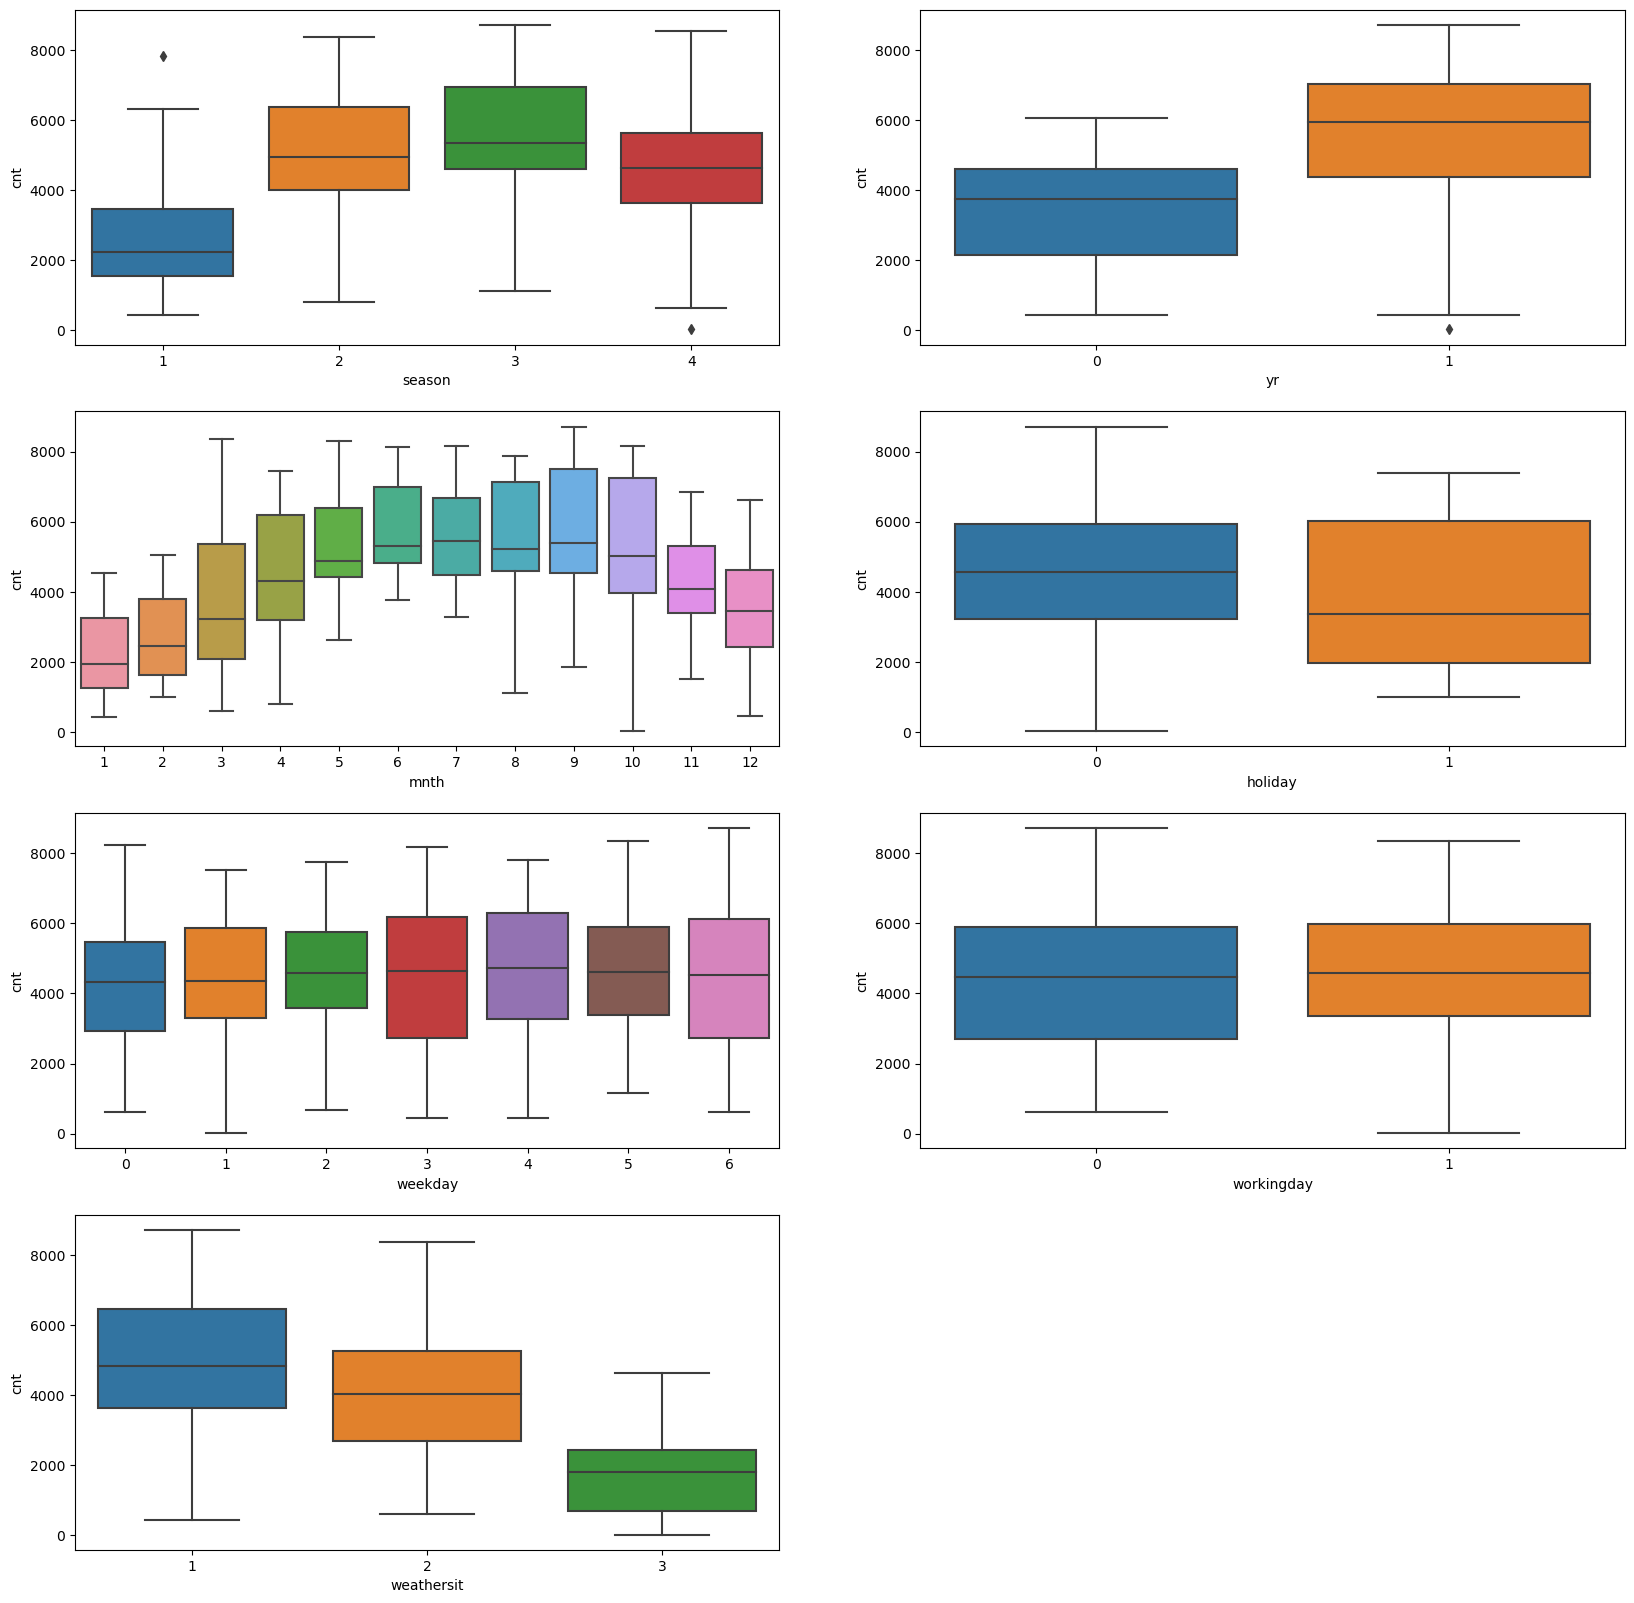

In [13]:
# box plot among categorical variables and target variable

plt.figure(figsize=(20, 20))

for i in range(0, len(categorical_vars)):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x = data[categorical_vars[i]], y = data[target_var])

plt.show()

## 4. Data preparation

In [14]:
# handle categorical variables

data = pd.get_dummies(data, columns=['season', 'mnth', 'weekday', 'weathersit'], drop_first=True, dtype='int32')
data[['yr', 'holiday', 'workingday']] = data[['yr', 'holiday', 'workingday']].apply(lambda x: x.astype('int32'))

In [15]:
# split train and test data with 70-30 rule

train_data, test_data = train_test_split(data, train_size=0.7, random_state=100)

print(train_data.shape)
print(test_data.shape)

(510, 30)
(220, 30)


In [16]:
# rescaling on train data

scalar = MinMaxScaler()
scalar.fit(train_data[numeric_vars])
train_data[numeric_vars] = scalar.transform(train_data[numeric_vars])

In [17]:
train_data.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.247059,0.262745,...,0.086275,0.084314,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.345098,0.029412
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.431725,0.440557,...,0.281045,0.278131,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 5. Model building

In [18]:
# compute X_train and y_train

X_train = train_data.drop(columns=['cnt'], axis = 1)
y_train = train_data['cnt']

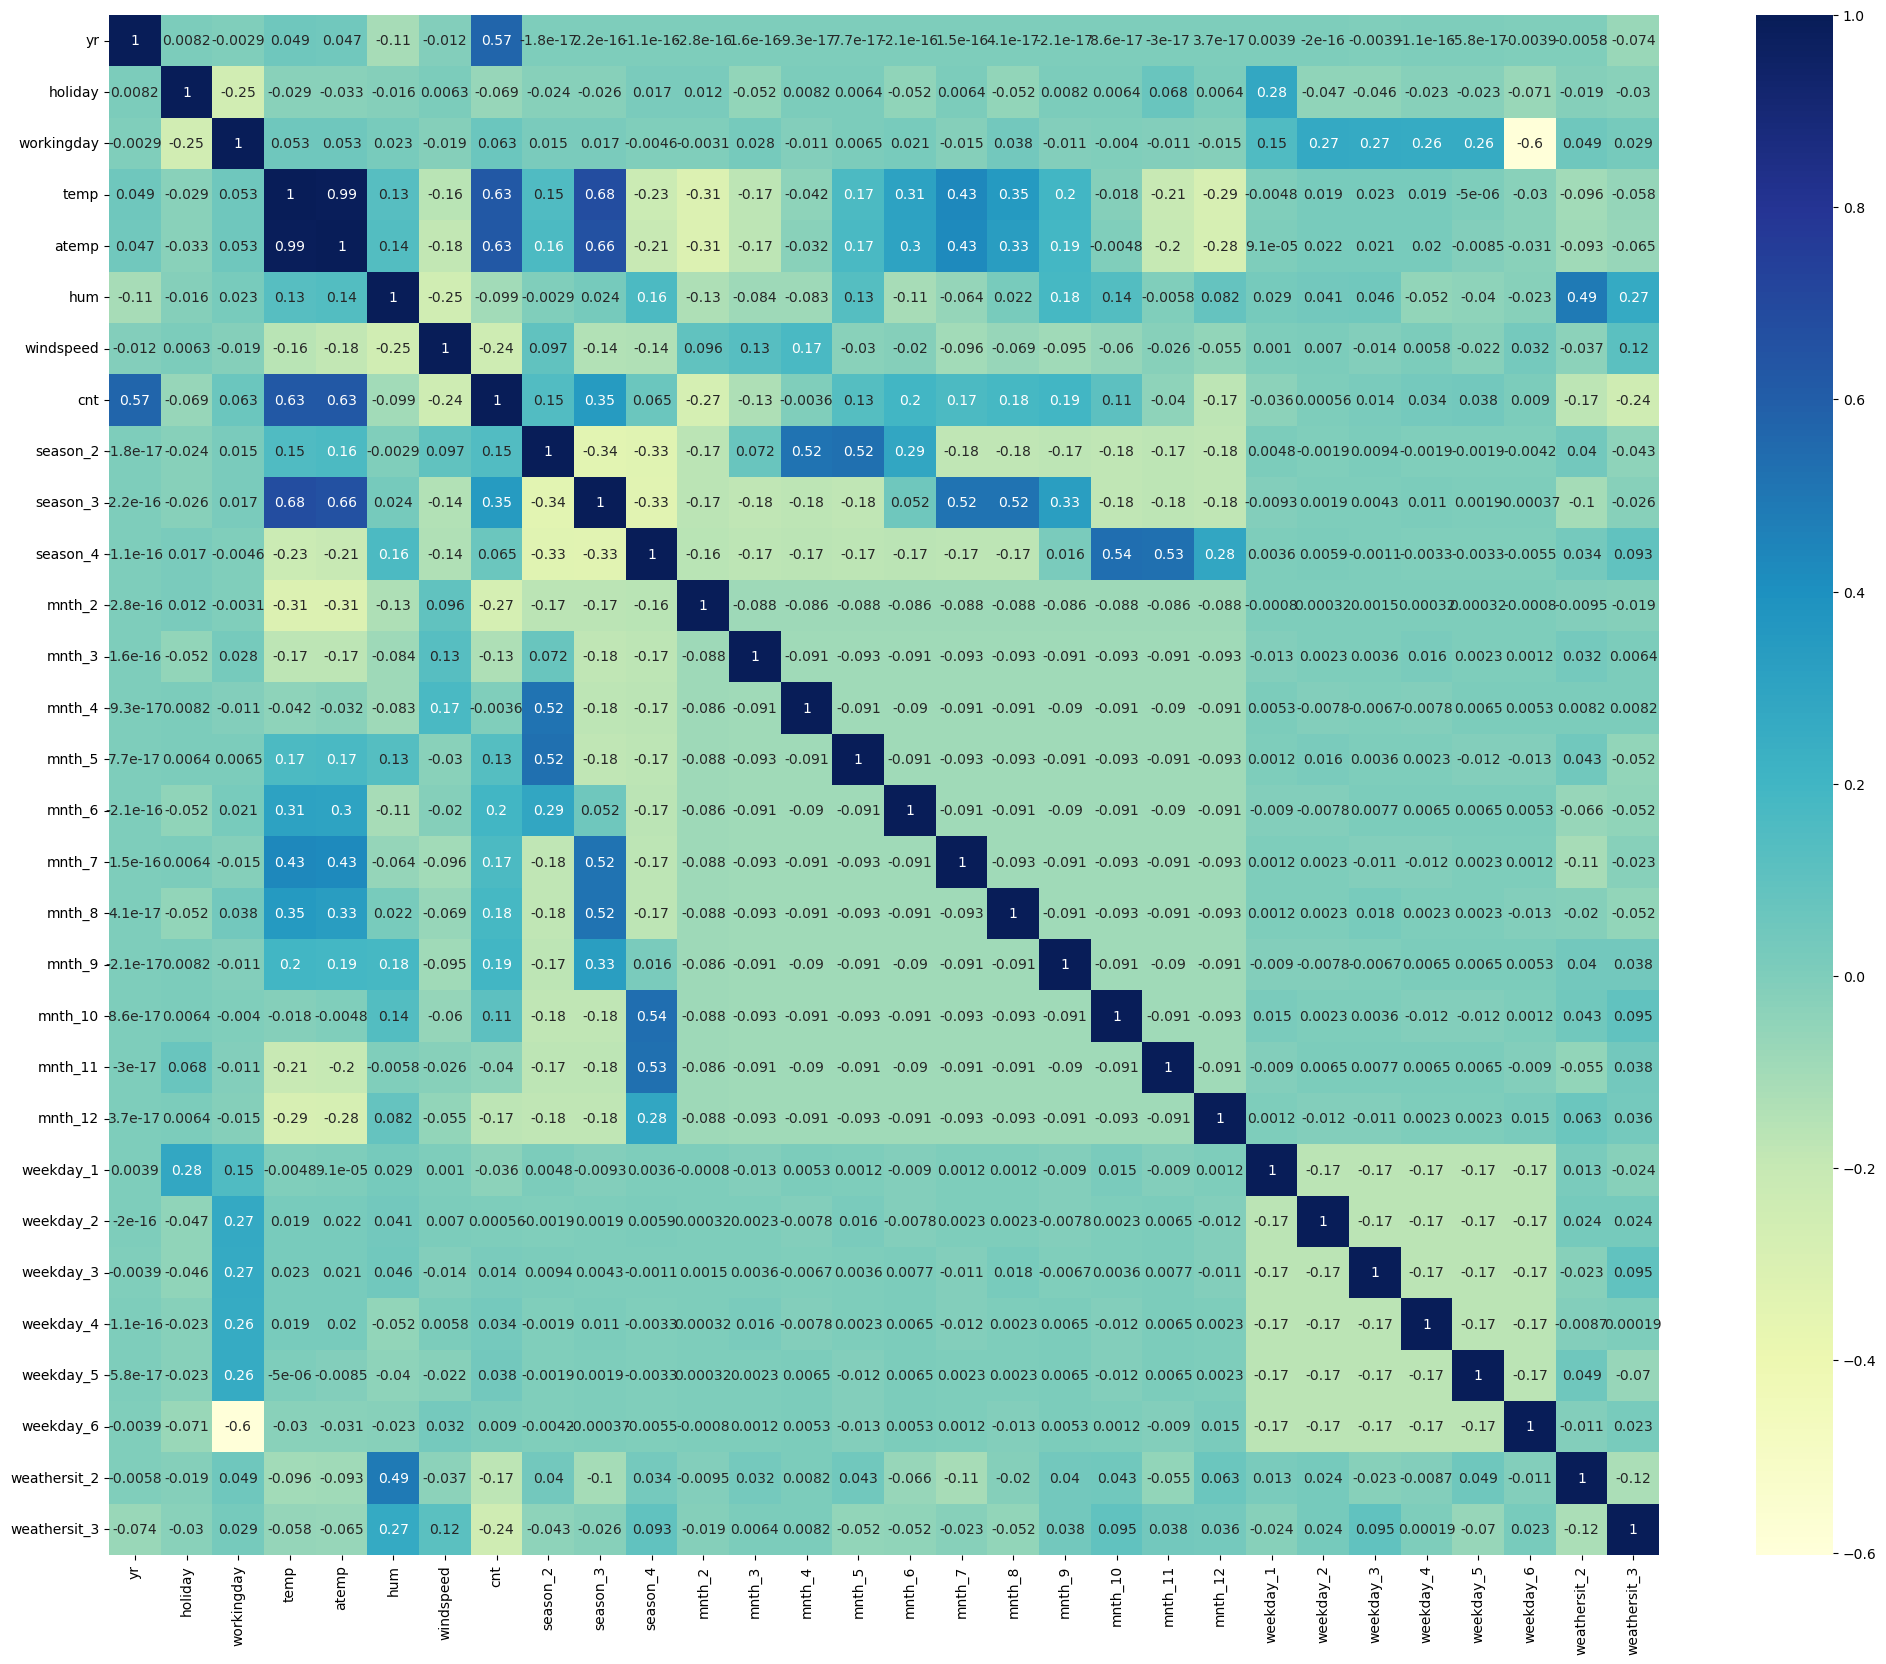

In [19]:
#  check pair wise correlations in data for multicollinearity detection

plt.figure(figsize = (25,20))
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')
plt.show()

In [20]:
# function definition for vif computation

def compute_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(0, X.shape[1])]
    vif = vif.sort_values(by = 'VIF', ascending=False)
    
    return vif

In [21]:
# function definition to construct model

def build_model(X, y, num_of_features=None):
    if num_of_features != None:
        # consturct linear model for feature selection
        lr = LinearRegression()
        lr.fit(X, y)

        # top n feature selection with RFE
        rfe = RFE(lr, n_features_to_select=num_of_features)
        rfe.fit(X, y)

        # remove unnecessary features
        print(X.columns[rfe.support_])
        X = X.drop(columns = X.columns[~rfe.support_])
    
    # build model
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    
    # compute vif
    vif_vals = compute_vif(X)
    
    return model, vif_vals

### Build model 1 with top 25 features

In [22]:
lr_model, lr_vif_vals = build_model(X_train, y_train, num_of_features=25)
print(lr_model.summary())
print(lr_vif_vals)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          5.16e-183
Time:                        14:59:04   Log-Likelihood:                 526.33
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     484   BIC:                            -890.6
Df Model:                          25     

### Build model 2 with top 20 features

In [23]:
lr_model, lr_vif_vals = build_model(X_train, y_train, num_of_features=20)
print(lr_model.summary())
print(lr_vif_vals)

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_8', 'mnth_9', 'mnth_10', 'weekday_6', 'weathersit_2',
       'weathersit_3'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     139.7
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          1.53e-187
Time:                        14:59:04   Log-Likelihood:                 524.48
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     489   BIC:                            -918.0
Df Model:                          20                                         
Covariance Type:  

### Build model 3 with top 15 features

In [24]:
lr_model, lr_vif_vals = build_model(X_train, y_train, num_of_features=15)
print(lr_model.summary())
print(lr_vif_vals)

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'mnth_8', 'mnth_9', 'mnth_10', 'weekday_6',
       'weathersit_2', 'weathersit_3'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     183.9
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          5.17e-191
Time:                        14:59:04   Log-Likelihood:                 519.44
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                     

### Build model 4 after removing season_3 column

In [25]:
X_train = X_train[lr_vif_vals['Features'].values]
X_train = X_train.drop(columns=['season_3'])

In [26]:
lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals) 

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          8.70e-192
Time:                        14:59:04   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1948      0.029      6.769   

### Build model 5 after removing humidity column

In [27]:
X_train = X_train.drop(columns=['hum'])

In [28]:
lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.8
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          1.97e-188
Time:                        14:59:04   Log-Likelihood:                 507.76
No. Observations:                 510   AIC:                            -987.5
Df Residuals:                     496   BIC:                            -928.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0937      0.019      4.914   

### Build model 6 after removing mnth_10 column

In [29]:
X_train = X_train.drop(columns=['mnth_10'])
lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.0
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          8.64e-189
Time:                        14:59:04   Log-Likelihood:                 505.81
No. Observations:                 510   AIC:                            -985.6
Df Residuals:                     497   BIC:                            -930.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0903      0.019      4.740   

### Build model 7 after removing holiday column

In [30]:
X_train = X_train.drop(columns=['holiday'])
lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     234.9
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          4.31e-189
Time:                        14:59:04   Log-Likelihood:                 503.70
No. Observations:                 510   AIC:                            -983.4
Df Residuals:                     498   BIC:                            -932.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0809      0.019      4.365   

### Build model 8 after removing mnth_8 column

In [31]:
X_train = X_train.drop(columns=['mnth_8'])
lr_model, lr_vif_vals = build_model(X_train, y_train)
print(lr_model.summary())
print(lr_vif_vals)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Sun, 31 Mar 2024   Prob (F-statistic):          3.13e-188
Time:                        14:59:04   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0750      0.019      4.031   

## 6. Residual analysis on trained model

In [32]:
# p-values of model

round(lr_model.pvalues, 3)

const           0.0
temp            0.0
workingday      0.0
windspeed       0.0
season_2        0.0
season_4        0.0
weathersit_2    0.0
yr              0.0
weekday_6       0.0
mnth_9          0.0
weathersit_3    0.0
dtype: float64

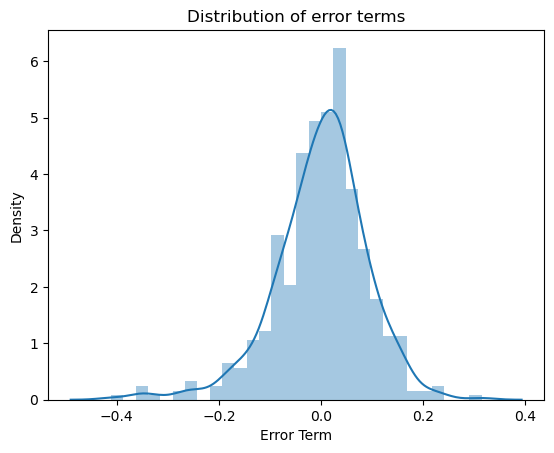

In [33]:
# computation of error terms

X_train_sm = sm.add_constant(X_train)
y_train_pred = lr_model.predict(X_train_sm)
err_terms_pred = y_train - y_train_pred

sns.distplot(err_terms_pred)
plt.xlabel('Error Term')
plt.title('Distribution of error terms')
plt.show()

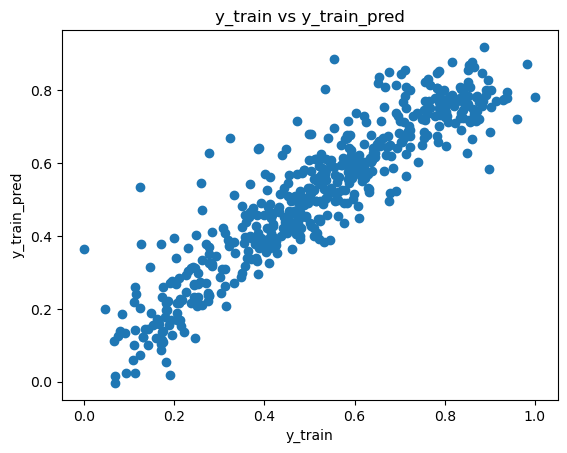

In [34]:
# scatter plot between y_train and y_train_pred

plt.scatter(x = y_train, y = y_train_pred)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')
plt.title('y_train vs y_train_pred')
plt.show()

## 7. Data preparation on testing dataset

In [35]:
# rescaling on test data

test_data[numeric_vars] = scalar.transform(test_data[numeric_vars])
test_data.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,1,...,0,0,1,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,1,0,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,1,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,1,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,1,0,...,0,0,0,0,0,1,0,0,0,0


In [36]:
# create X_test and y_test

X_test = test_data[X_train.columns]
y_test = test_data['cnt']

## 8. Predections on test data

In [37]:
# compute y_test_pred

X_test_sm = sm.add_constant(X_test)
y_test_pred = lr_model.predict(X_test_sm)

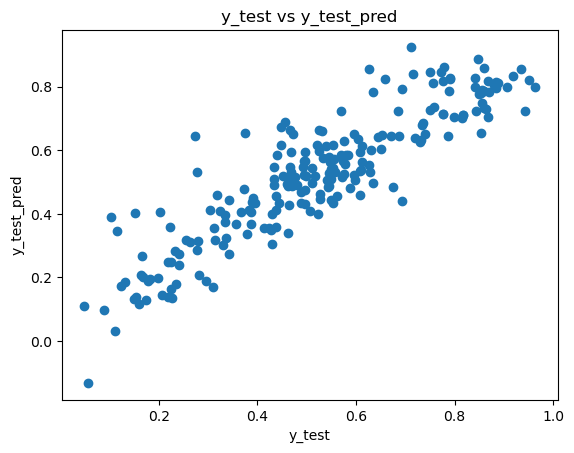

In [38]:
# scatter plot between y_test and y_test_pred

plt.scatter(x = y_test, y = y_test_pred)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.title('y_test vs y_test_pred')
plt.show()

## 9. Model evaluation

In [39]:
# compute r-squared value for train data

r2_train = round(lr_model.rsquared, 3)

In [40]:
# compute r-squared value for test data

r2_test = round(r2_score(y_true=y_test, y_pred=y_test_pred), 3)

In [41]:
# compute adjusted r-squared value for train data

adj_r2_train = round(lr_model.rsquared_adj, 3)

In [42]:
# compute adjusted r-squared value for test data

N = X_test.shape[0]
p = X_test.shape[1]
r2 = r2_test

adj_r2_test = round(1 - (1-r2)*(N-1) / (N-p-1), 3)

In [43]:
# print values

print('R-squared for trained data = {}'.format(r2_train))
print('Adjusted R-squared for trained data = {}'.format(adj_r2_train))

print('R-squared for test data = {}'.format(r2_test))
print('Adjusted R-squared for test data = {}'.format(adj_r2_test))

R-squared for trained data = 0.835
Adjusted R-squared for trained data = 0.832
R-squared for test data = 0.796
Adjusted R-squared for test data = 0.786


## 10. Conclusions

In [44]:
# parameters 

lr_model.params

const           0.075009
temp            0.549892
workingday      0.056117
windspeed      -0.155203
season_2        0.088621
season_4        0.130655
weathersit_2   -0.080022
yr              0.233139
weekday_6       0.067500
mnth_9          0.097365
weathersit_3   -0.287090
dtype: float64

In [45]:
# difference between train and test accuracy

round((adj_r2_train - adj_r2_test) * 100, 3)

4.6

In [46]:
# difference between train and test accuracy

round((r2_train - r2_test) * 100, 3)

3.9